# Binary SVC w/ Hiperparameter tunning (Grid Search, Random Search, Bayesian Opt, Bayes search, Optuna) & lifecycle management w/ MLFlow

In [1]:
# Importa librerias
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import cross_val_score, train_test_split

from scipy.stats import uniform

from sklearn.metrics import classification_report, roc_curve, auc

In [2]:
import warnings

# Suppress the warning
warnings.filterwarnings("ignore", message="Distutils was imported before Setuptools")

## Data loading & preprocessing

In [3]:
# Lee dataset
cols = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
df = pd.read_csv("../../data/raw/magic04.data", names=cols)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [4]:
# Valores de la variable objetivo
df['class'].unique()

array(['g', 'h'], dtype=object)

In [5]:
# Reclasifica variable objetivo - Class as int (g=1, h=0)

df['class'] = (df['class'] == "g").astype(int)

### General parameters

In [6]:
# Key to group & identify different runs
import datetime

mlf_key = datetime.datetime.now().strftime("%y%m%d%H%M")

# Load general parameters
import yaml

with open("../scripts_setup/General_params.yaml") as f:
    config_file = yaml.safe_load(f)

# General params
cv = config_file["General"]["cv"]
random_state = config_file["General"]["random_state"]
n_jobs = config_file["General"]["n_jobs"]
n_iter = config_file["General"]["n_iter"]            # BayesSearchCV, BayesianOptimization, RandomizedSearchCV
n_trials = config_file["General"]["n_trials"]           # Optuna trials 
init_points = config_file["General"]["init_points"]        # BayesianOptimization
# SVC range params
c_min = config_file["SVC"]["c_min"]
c_max = config_file["SVC"]["c_max"]
gamma_min = config_file["SVC"]["gamma_min"]
gamma_max = config_file["SVC"]["gamma_max"]
# MLFlow params
mlf_tracking_server_uri = config_file["MLFlow"]["tracking_server_uri"]
mlf_experiment_name = config_file["MLFlow"]["experiment_name"]
mlf_project_name = config_file["MLFlow"]["project_name"]
mlf_team = config_file["MLFlow"]["team"]

### Split dataset

In [7]:
# Shuffle with a fixed random state for reproducibility
data_shuffled = df.sample(frac=1, random_state=random_state)  

# Split data into training and temporary sets (80% training, 20% temp)
df_train, df_temp = train_test_split(data_shuffled, test_size=0.4, random_state=random_state)

# Split the temporary set into testing and validation sets (50% test, 50% validation)
df_test, df_valid = train_test_split(df_temp, test_size=0.5, random_state=random_state)

# Reset the indices of the resulting DataFrames
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

### Function for scaling and oversampling the dataset

In [8]:
def scale_dataset(df_param, random_state=None, oversample = False):
  X = df_param[df_param.columns[:-1]].values
  y = df_param[df_param.columns[-1]].values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  if oversample:
    ros = RandomOverSampler(random_state=random_state)
    X, y = ros.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1))))

  return data, X, y

### Scale & oversample

In [9]:
train, X_train, y_train = scale_dataset(df_train, random_state, oversample = True)
valid, X_valid, y_valid = scale_dataset(df_valid, random_state, oversample = False)
test, X_test, y_test = scale_dataset(df_test, random_state, oversample = False)

### Saves train / test / validation files & paths to log them in MLFlow

In [10]:
import os
# Save to CSV for logging
X_train_path = os.path.abspath("../../data/processed/X_train.csv")
y_train_path = os.path.abspath("../../data/processed/y_train.csv")
X_test_path = os.path.abspath("../../data/processed/X_test.csv")
y_test_path = os.path.abspath("../../data/processed/y_test.csv")
X_valid_path = os.path.abspath("../../data/processed/X_valid.csv")
y_valid_path = os.path.abspath("../../data/processed/y_valid.csv")

pd.DataFrame(X_train).to_csv(X_train_path, index=False)
pd.DataFrame(y_train).to_csv(y_train_path, index=False)
pd.DataFrame(X_test).to_csv(X_test_path, index=False)
pd.DataFrame(y_test).to_csv(y_test_path, index=False)
pd.DataFrame(X_valid).to_csv(X_valid_path, index=False)
pd.DataFrame(y_valid).to_csv(y_valid_path, index=False)

## MLFLow

### Initialize MLFlow experiment

In [11]:
import mlflow

# Code for init MLFLOW server: mlflow server --host 127.0.0.1 --port 5000
#mlf_tracking_server_uri = "http://localhost:5000"
mlflow.set_tracking_uri(mlf_tracking_server_uri)

#mlf_experiment_name = "Magic"
mlf_experiment_description = "This is a(n) " + mlf_experiment_name + " experiment initiated on " + mlf_key
mlf_experiment_tags = {
    "project_name": mlf_project_name,
    "team": mlf_team,
    "mlflow.note.content": mlf_experiment_description,
}

try:
    mlf_exp_id = mlflow.create_experiment(name=mlf_experiment_name, tags=mlf_experiment_tags)
except Exception as e:
    mlf_exp_id = mlflow.get_experiment_by_name(mlf_experiment_name).experiment_id

mlflow.sklearn.autolog(disable=True)    
#print("Experiment ID:", mlf_exp_id)

### MLFlow procedures

In [12]:
def mlf_log_tags_params (model_name, model_desc, C, gamma, kernel, X_train_path, y_train_path, X_test_path, y_test_path):
    try:
        mlflow.set_tag("model_name", model_name)          
        mlflow.set_tag("model_description", model_desc)
        mlflow.set_tag('X_Train', X_train_path) 
        mlflow.set_tag('y_train', y_train_path) 
        mlflow.set_tag('X_test', X_test_path) 
        mlflow.set_tag('y_test', y_test_path) 
        mlflow.log_param('C', C)    
        mlflow.log_param('gamma', gamma)    
        mlflow.log_param('kernel', kernel)  
    except Exception as e:
        print(f"Error mlf_log_tags_params: {e}")

def mlf_log_tags_gen (cv, random_state, n_jobs, n_iter, n_trials, init_points, c_min, c_max, gamma_min, gamma_max):    
    try:
        mlflow.set_tag("cv", cv)
        mlflow.set_tag("random_state", random_state)
        mlflow.set_tag("n_jobs", n_jobs)
        mlflow.set_tag("n_iter", n_iter)
        mlflow.set_tag("n_trials", n_trials)
        mlflow.set_tag("init_points", init_points)
        mlflow.set_tag("c_min", c_min)
        mlflow.set_tag("c_max", c_max)
        mlflow.set_tag("gamma_min", gamma_min)
        mlflow.set_tag("gamma_max", gamma_max)
    except Exception as e:
        print(f"Error mlf_log_tags_gen: {e}")


def mlf_log_metrics_models(class_report, model, tag, auc):
    try:
        mlflow.log_metric("accuracy", class_report["accuracy"])
        mlflow.log_metric("AUC", auc)
        
        for class_name, metrics in class_report.items():
            if class_name not in ["macro avg", "weighted avg"]:
                if isinstance(metrics, dict):  
                    for metric, value in metrics.items():
                        if metric in ["precision", "recall", "f1-score", "support"]:
                            mlflow.log_metric(f"{metric}_{class_name}", value)    
        #mlflow.log_figure(fig8, "qq_plot.png")
        mlflow.sklearn.log_model(model, tag) 
    except Exception as e:
        print(f"Error mlf_log_metrics_models: {e}")

def log_metrics_auc_intervals(svc_fpr, svc_tpr):
    try:
        # Define the intervals (e.g., 10%, 20%, ..., 90%)
        intervals = range(10, 91, 10)  # 10, 20, ..., 90        
        # Initialize a dictionary to store the AUC for each interval
        auc_intervals = {}        
        # Compute the total number of data points
        total_points = len(svc_fpr)
        
        # Loop through each interval
        for interval in intervals:
            # Calculate the index up to which the current interval falls
            index = int((interval / 100) * total_points)            
            # Extract the FPR and TPR values up to the current index
            fpr_interval = svc_fpr[:index + 1]
            tpr_interval = svc_tpr[:index + 1]            
            # Compute the AUC for the current interval
            auc_interval = auc(fpr_interval, tpr_interval)            
            # Store the AUC for the current interval
            auc_intervals[interval] = auc_interval
            
        for interval, auc_interval in auc_intervals.items():
            #print(f"AUC for {interval}%: {auc_interval}")  
            mlflow.log_metric(f"AUC for {interval} perc", auc_interval)
    except Exception as e:
        print(f"Error log_metrics_auc_intervals: {e}")

## Model

### SVC base

In [13]:
%%time

# SVC
from sklearn.svm import SVC

# Init MLFlow run
with mlflow.start_run(experiment_id=mlf_exp_id, run_name= mlf_key + '_SVC_Baseline'):  
    #mlflow.sklearn.autolog()

    # Create algo object, train & predict
    svc_model = SVC(random_state=random_state)
    svc_model.fit(X_train, y_train)
    y_pred = svc_model.predict(X_test)
    y_pred_base = svc_model.decision_function(X_test)
    
    # Get the hyperparameters of the trained model
    best_params = svc_model.get_params()
    
    # Log tags & params in MLFlow 
    mlf_log_tags_gen (cv, random_state, n_jobs, n_iter, n_trials, init_points, c_min, c_max, gamma_min, gamma_max)
    mlf_log_tags_params("SVC_Baseline", "Baseline SVC", best_params['C'], best_params['gamma'], best_params['kernel'], X_train_path, y_train_path, X_test_path, y_test_path)
    
    # Values for getting AUC
    base_fpr, base_tpr, threshold = roc_curve(y_test, y_pred_base)
    auc_base = auc(base_fpr, base_tpr)

    # Log metrics & model in MLFlow
    mlf_log_metrics_models(classification_report(y_test, y_pred, output_dict=True), svc_model, "SVC_Baseline", auc_base)
    log_metrics_auc_intervals(base_fpr, base_tpr)

    # End MLFlow run
    mlflow.end_run()

2024/03/12 17:52:21 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



CPU times: total: 17.9 s
Wall time: 26 s


### SVC Grid search

In [14]:
%%time

# SVM Grid search
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the grid search
param_grid = {
    #'kernel': ['linear', 'rbf', 'poly'],    # Types of kernel functions
    #'C': [0.001, 1, 50, 100, 1000],                 # Values of the regularization parameter
    #'gamma': ['scale', 'auto']              # Kernel coefficient for 'rbf' kernel

    'kernel': ['linear'],    
    'C': [0.001, 1],                 
    'gamma': ['scale', 'auto']              
    }

# Create the GridSearchCV object
grid_search_svc = GridSearchCV(svc_model, param_grid, cv=cv, scoring='accuracy', verbose=2)

# Perform the grid search on training data
grid_search_svc.fit(X_train, y_train)

# Start MLFlow run
with mlflow.start_run(experiment_id=mlf_exp_id, run_name= mlf_key + '_SVC_best_GridSearch'):  
    #mlflow.sklearn.autolog()
    
    # Get hyperparameters of the best trained model
    best_params = grid_search_svc.best_params_
    
    # Get best trained model
    best_svc = grid_search_svc.best_estimator_
    
    # train & predict
    y_pred = best_svc.predict(X_test)
    y_pred_gridsearch = best_svc.decision_function(X_test)
    
    # Log tags & params in MLFlow  
    mlf_log_tags_gen (cv, random_state, n_jobs, n_iter, n_trials, init_points, c_min, c_max, gamma_min, gamma_max)
    mlf_log_tags_params("SVC_best_gridsearch", "Best Grid Search SVC", best_params['C'], best_params['gamma'], best_params['kernel'], X_train_path, y_train_path, X_test_path, y_test_path)
    
    # Values for getting AUC
    gridsearch_svc_fpr, gridsearch_svc_tpr, threshold = roc_curve(y_test, y_pred_gridsearch)
    auc_gridsearch_svc = auc(gridsearch_svc_fpr, gridsearch_svc_tpr)
    
    # Log metrics & model in MLFlow
    mlf_log_metrics_models(classification_report(y_test, y_pred, output_dict=True), best_svc, "SVC_best_GridSearch", auc_gridsearch_svc)
    log_metrics_auc_intervals(gridsearch_svc_fpr, gridsearch_svc_tpr)

    # End MLFlow run
    mlflow.end_run()

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   4.4s
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   5.1s
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   4.6s
[CV] END .................C=0.001, gamma=auto, kernel=linear; total time=   4.9s
[CV] END .................C=0.001, gamma=auto, kernel=linear; total time=   4.7s
[CV] END .................C=0.001, gamma=auto, kernel=linear; total time=   4.2s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   5.8s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   7.0s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   5.7s
[CV] END .....................C=1, gamma=auto, kernel=linear; total time=   6.1s
[CV] END .....................C=1, gamma=auto, kernel=linear; total time=  12.1s
[CV] END .....................C=1, gamma=auto, ke

C:\Users\Ale\anaconda3\envs\ML101\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


CPU times: total: 1min 24s
Wall time: 1min 39s


### SVC Random search

In [15]:
%%time

# SVM Random search
from sklearn.model_selection import RandomizedSearchCV

# Define parameter distributions for the random search
param_dist = {'C': uniform(c_min, c_max),
              'gamma': ['scale', 'auto'],
 #'gamma': uniform(0.01, 10),
              'kernel': ['rbf', 'linear', 'poly']}

# Create the RandomizedSearchCV object
random_search_svm = RandomizedSearchCV(svc_model, param_distributions=param_dist, cv=cv, n_iter=n_iter, random_state=random_state, verbose=2)

# Perform the random search on the training data
random_search_svm.fit(X_train, y_train)

# Start MLFlow run
with mlflow.start_run(experiment_id=mlf_exp_id, run_name= mlf_key + '_SVC_best_RandomSearch'):  
    #mlflow.sklearn.autolog()
    
    # Get hyperparameters of the best trained model
    best_params = random_search_svm.best_params_
    
    # Get best trained model
    best_svc = random_search_svm.best_estimator_

    # train & predict
    y_pred = best_svc.predict(X_test)
    y_pred_randomsearch = best_svc.decision_function(X_test)

    # Log tags & params in MLFlow
    mlf_log_tags_gen (cv, random_state, n_jobs, n_iter, n_trials, init_points, c_min, c_max, gamma_min, gamma_max)
    mlf_log_tags_params("SVC_best_randomsearch", "Best Random Search SVC", best_params['C'], best_params['gamma'], best_params['kernel'], X_train_path, y_train_path, X_test_path, y_test_path)

    # Values for getting AUC
    randomsearch_svc_fpr, randomsearch_svc_tpr, threshold = roc_curve(y_test, y_pred_randomsearch)
    auc_randomsearch_svc = auc(randomsearch_svc_fpr, randomsearch_svc_tpr)

    # Log metrics & model in MLFlow
    mlf_log_metrics_models(classification_report(y_test, y_pred, output_dict=True), best_svc, "SVC_best_RandomSearch", auc_randomsearch_svc)
    log_metrics_auc_intervals(randomsearch_svc_fpr, randomsearch_svc_tpr)

    # End MLFlow run
    mlflow.end_run()

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ......C=208.46153735884263, gamma=scale, kernel=rbf; total time=  12.3s
[CV] END ......C=208.46153735884263, gamma=scale, kernel=rbf; total time=  13.9s
[CV] END ......C=208.46153735884263, gamma=scale, kernel=rbf; total time=  14.0s
[CV] END .......C=420.5390353143747, gamma=scale, kernel=rbf; total time=  18.4s
[CV] END .......C=420.5390353143747, gamma=scale, kernel=rbf; total time=  18.0s
[CV] END .......C=420.5390353143747, gamma=scale, kernel=rbf; total time=  19.7s


C:\Users\Ale\anaconda3\envs\ML101\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


CPU times: total: 2min 14s
Wall time: 2min 27s


### SVC Bayesian optimization

In [16]:
%%time

# SVM Bayesian optimization - BayesianOptimization
from bayes_opt import BayesianOptimization

# To specify the kernel
kernel='rbf' 

# SVM objective function with cross-validation
def svm_cv(C, gamma):    
    svm = SVC(C=C, gamma=gamma, kernel=kernel, random_state=random_state) ### en vez de usar svm se puede pasar el svc_model / capaz cambiar el nombre de la funcion?
    scores = cross_val_score(svm, X_train, y_train, cv=cv, scoring='accuracy')
    return np.mean(scores)

# Define the search space
pbounds = {'C': (c_min, c_max), 
           'gamma': (gamma_min, gamma_max)
          }

# Create the Bayesian optimizer
bayes_optimizer_svm = BayesianOptimization(
    f=svm_cv,
    pbounds=pbounds,
    random_state=random_state  
)

# Perform the search on the training data
bayes_optimizer_svm.maximize(init_points=init_points, n_iter=n_iter)

# Start MLFlow run
with mlflow.start_run(experiment_id=mlf_exp_id, run_name= mlf_key + '_SVC_best_BayesianOptimization'):  
    #mlflow.sklearn.autolog()
    
    # Get hyperparameters of the best trained model
    best_params = bayes_optimizer_svm.max['params']

    # Get best trained model    
    best_svc = SVC(**best_params)
    # train & predict
    best_svc.fit(X_train, y_train)
    y_pred = best_svc.predict(X_test)
    y_pred_bayesianoptimization = best_svc.decision_function(X_test)

    # Log tags & params in MLFlow
    mlf_log_tags_gen (cv, random_state, n_jobs, n_iter, n_trials, init_points, c_min, c_max, gamma_min, gamma_max)
    mlf_log_tags_params("SVC_best_BayesianOptimization", "Best Bayesian Optimization SVC", best_params['C'], best_params['gamma'], best_svc.get_params()['kernel'], X_train_path, y_train_path, X_test_path, y_test_path)

    # Values for getting AUC
    bayesianoptimization_svc_fpr, bayesianoptimization_svc_tpr, threshold = roc_curve(y_test, y_pred_bayesianoptimization)
    auc_bayesianoptimization_svc = auc(bayesianoptimization_svc_fpr, bayesianoptimization_svc_tpr)

    # Log metrics & model in MLFlow
    mlf_log_metrics_models(classification_report(y_test, y_pred, output_dict=True), best_svc, "SVC_best_BayesianOptimization", auc_bayesianoptimization_svc)
    log_metrics_auc_intervals(bayesianoptimization_svc_fpr, bayesianoptimization_svc_tpr)

    # End MLFlow run
    mlflow.end_run()

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | 0.8776    | 208.5     | 4.817     |
| 2         | 0.8356    | 420.5     | 8.592     |
| 3         | 0.8786    | 207.6     | 4.111     |
| 4         | 0.8655    | 168.9     | 0.07997   |


C:\Users\Ale\anaconda3\envs\ML101\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


CPU times: total: 4min 6s
Wall time: 4min 23s


### SVC Bayes search

In [17]:
%%time

# SVM Bayesian optimization - BayesSearchCV
from skopt import BayesSearchCV

# Define the search space
param_space = {
    'C': (c_min, c_max, 'log-uniform'),  
    'gamma': (gamma_min, gamma_max, 'log-uniform')  
}

# Initialize BayesSearchCV object
bayes_search_svm = BayesSearchCV(
    SVC(random_state=random_state), # pasar svc_model
    param_space,
    n_iter=n_iter,
    n_jobs=n_jobs,
    cv=cv
)

#print(bayes_search_svm.best_params_)

# Perform the search on the training data
bayes_search_svm.fit(X_train, y_train)

# Start MLFlow run
with mlflow.start_run(experiment_id=mlf_exp_id, run_name= mlf_key + '_SVC_best_BayesSearch'): 
    #mlflow.sklearn.autolog()
    
    # Get hyperparameters of the best trained model
    best_params = bayes_search_svm.best_params_
    
    # Get best trained model
    best_svc = bayes_search_svm.best_estimator_
    # train & predict
    
    y_pred = best_svc.predict(X_test)
    y_pred_bayessearch = best_svc.decision_function(X_test)
    
    # Log tags & params in MLFlow
    mlf_log_tags_gen (cv, random_state, n_jobs, n_iter, n_trials, init_points, c_min, c_max, gamma_min, gamma_max)
    mlf_log_tags_params("SVC_best_BayesSearch", "Best Bayes Search SVC", best_params['C'], best_params['gamma'], best_svc.get_params()['kernel'], X_train_path, y_train_path, X_test_path, y_test_path)
    
    # Values for getting AUC
    bayessearch_svc_fpr, bayessearch_svc_tpr, threshold = roc_curve(y_test, y_pred_bayessearch)
    auc_bayessearch_svc = auc(bayessearch_svc_fpr, bayessearch_svc_tpr)
    
    # Log metrics & model in MLFlow
    mlf_log_metrics_models(classification_report(y_test, y_pred, output_dict=True), best_svc, "SVC_best_BayesSearch", auc_bayessearch_svc)
    log_metrics_auc_intervals(bayessearch_svc_fpr, bayessearch_svc_tpr)
    
    # End MLFlow run
    mlflow.end_run()

{'C': (0.001, 1000.0, 'log-uniform'), 'gamma': (0.0001, 10.0, 'log-uniform')}
0.001
<class 'float'>
1000.0
<class 'float'>
0.0001
<class 'float'>
10.0
<class 'float'>
22
<class 'int'>
2
<class 'int'>
-1
<class 'int'>
3
<class 'int'>
0


C:\Users\Ale\anaconda3\envs\ML101\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


CPU times: total: 39.2 s
Wall time: 3min 3s


### SVC Optuna

In [20]:
%%time

import optuna
from optuna.samplers import TPESampler
#import optuna.visualization as vis

# SVM objective function
def objective(trial):
    C = trial.suggest_float('C', c_min, c_max, log=True)
    gamma = trial.suggest_float('gamma', gamma_min, gamma_max, log=True)    
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf'])

    svc = SVC(C=C, gamma=gamma, kernel=kernel)
    
    # Supongamos que X_train, y_train están definidos
    score = cross_val_score(svc, X_train, y_train, n_jobs=n_jobs, cv=cv).mean()

    # To save trials in current MLFlow run
    # with mlflow.start_run(experiment_id=mlf_exp_id, run_name= mlf_key + '_SVC_trial_Optuna_' + str(trial.number)):  
    #     mlflow.log_params(trial.params)
    #     mlflow.log_metric('score', score)
    #     # Set Optuna's trial id as the parent run ID for tracking
    #     mlflow.set_tag("parent_id", str(trial.number))
    #     mlflow.end_run()
    return score

# Perform the search on the training data
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(sampler=TPESampler(), direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=n_trials)

# Start MLFlow run
with mlflow.start_run(experiment_id=mlf_exp_id, run_name= mlf_key + '_SVC_best_Optuna'):  
    #mlflow.sklearn.autolog()
    
    # Get hyperparameters of the best trained model
    best_params = study.best_params
    
    # Get best trained model
    best_svc = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'])
    best_svc.fit(X_train, y_train)
    
    # train & predict
    y_pred = best_svc.predict(X_test)
    y_pred_optuna = best_svc.decision_function(X_test)

    # Log tags & params in MLFlow
    mlf_log_tags_gen (cv, random_state, n_jobs, n_iter, n_trials, init_points, c_min, c_max, gamma_min, gamma_max)
    mlf_log_tags_params("SVC_best_Optuna", "Best Optuna SVC", best_params['C'], best_params['gamma'], best_params['kernel'], X_train_path, y_train_path, X_test_path, y_test_path)

    # Values for getting AUC
    optuna_svc_fpr, optuna_svc_tpr, threshold = roc_curve(y_test, y_pred_optuna)
    auc_optuna_svc = auc(optuna_svc_fpr, optuna_svc_tpr)

    # Log metrics & model in MLFlow
    mlf_log_metrics_models(classification_report(y_test, y_pred, output_dict=True), best_svc, "SVC_best_Optuna", auc_optuna_svc)
    log_metrics_auc_intervals(optuna_svc_fpr, optuna_svc_tpr)

    # End MLFlow run
    mlflow.end_run()

[I 2024-03-12 18:16:25,540] A new study created in memory with name: no-name-35a0a93e-4cdb-4eb9-b209-8802a6a33751
[I 2024-03-12 18:16:34,288] Trial 0 finished with value: 0.7702134486337421 and parameters: {'C': 0.03272609496339658, 'gamma': 0.0002900838976818291, 'kernel': 'linear'}. Best is trial 0 with value: 0.7702134486337421.
[I 2024-03-12 18:16:43,768] Trial 1 finished with value: 0.7667656801110224 and parameters: {'C': 0.004688419774494571, 'gamma': 0.00010701960382823416, 'kernel': 'linear'}. Best is trial 0 with value: 0.7702134486337421.
C:\Users\Ale\anaconda3\envs\ML101\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


CPU times: total: 8.92 s
Wall time: 38.3 s


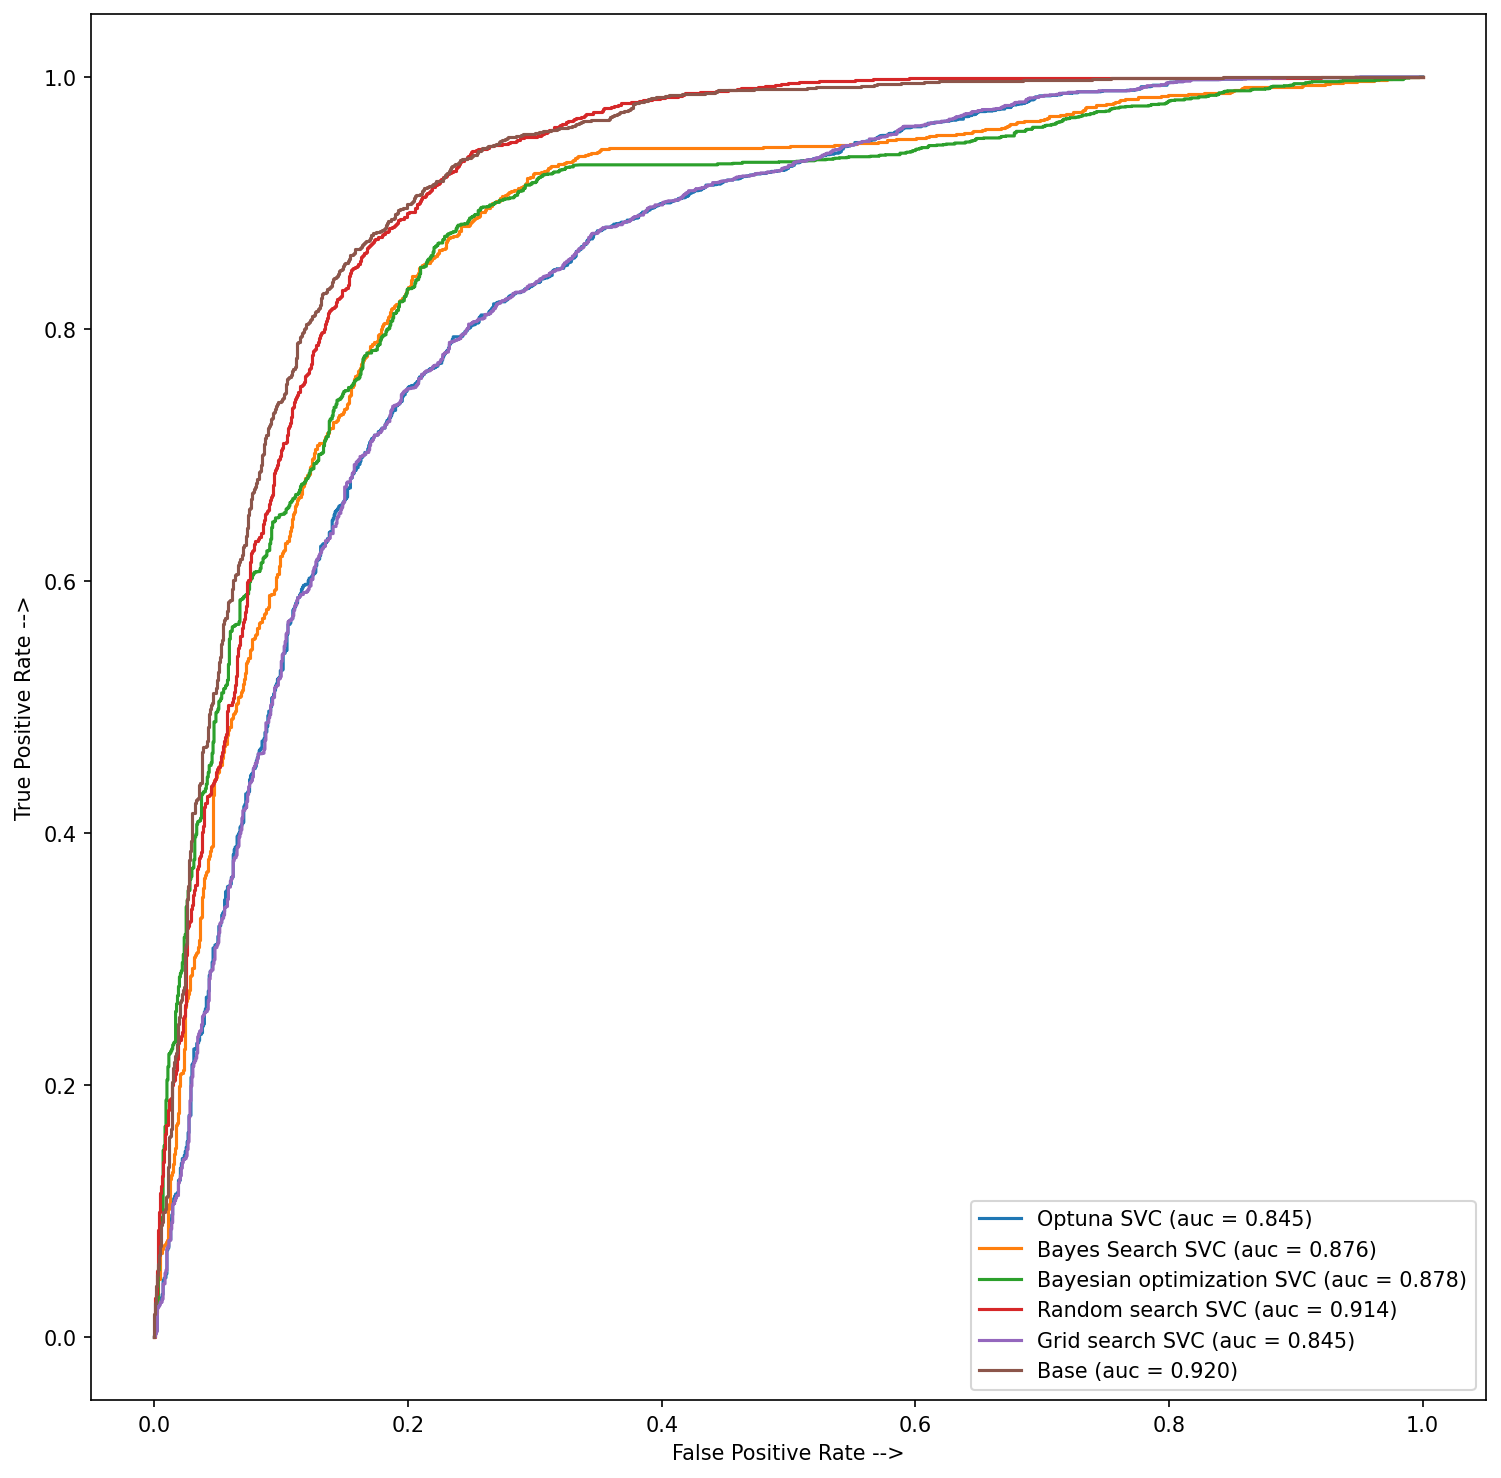

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12), dpi=150)
plt.plot(optuna_svc_fpr, optuna_svc_tpr, label='Optuna SVC (auc = %0.3f)' % auc_optuna_svc)
plt.plot(bayessearch_svc_fpr, bayessearch_svc_tpr, label='Bayes Search SVC (auc = %0.3f)' % auc_bayessearch_svc)
plt.plot(bayesianoptimization_svc_fpr, bayesianoptimization_svc_tpr, label='Bayesian optimization SVC (auc = %0.3f)' % auc_bayesianoptimization_svc)
plt.plot(randomsearch_svc_fpr, randomsearch_svc_tpr, label='Random search SVC (auc = %0.3f)' % auc_randomsearch_svc)
plt.plot(gridsearch_svc_fpr, gridsearch_svc_tpr, label='Grid search SVC (auc = %0.3f)' % auc_gridsearch_svc)
plt.plot(base_fpr, base_tpr, label='Base (auc = %0.3f)' % auc_base)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [ ]:
# MLflow guarda los resultados sin especificar bd? - si
# agregar como metrica resultados del classification report - si
# agregar descripcion - si
# hacer que cargue todas las corridas de optuna? - si
# hacer que la aleatoriedad al hacer validation y test sean fijas - si
# meter los demas algoritmos - base - optuna - gridsearch - random search - bayesian optimization - bayes search - si
# poner en funciones lo de MLFlow, optuna quizas - si
# guardar dataset (train/test/val) en mlflow - si
# guardar criterios de split dataset (train/test/val) en mlflow - si
# guardar ini/fin de algoritmos - si
# guardar parametros generales - si
# que pasa al correr varias veces esto con el experimento - si
#    hacer que cargue diferentes valores? - si
# validar si optuna da resultados diferentes, por que? - si
# graficar curva ROC; se puede con accuracy, precission, recal, f1, etc? - si
# tirar a git - si
# documentar - si
# YAML config file for general variables - si

# meter KNN, naive bayes, log regressopn
# usar Accuracy & AUC como objetivo en los algoritmos
# usar score & probability en los algoritmos
# data validation, 
#     son los datasets similares en extructura
#     son los datasets similares en valores
# hiperparemeter validation
# error handling
#    MLFlow error
#    Train / test error
# train, test, validation best practices

# logged table artifacts en mlflow? - na